# Practical Exercise 6
## Statistical analysis Correlation, Confidence intervals and Regression
The goal of this practical exercise is to study confidence intervals of various statistical measures, such as regression, correlation coefficient and data samples.

In [2]:
# Task One

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

CONFIDENCE_CORR = 0.84
CONFIDENCE_REG = 0.92
CONFIDENCE_DATA = 0.91

np.random.seed(42)
n_samples = 200

cpu_temperature = np.random.normal(70, 10, n_samples)
performance_score = 100 - (cpu_temperature - 70) * 1.5 + np.random.normal(0, 5, n_samples)
workload_types = np.random.choice(["Gaming", "Video Editing", "Machine Learning"], n_samples)

df = pd.DataFrame({
    "cpu_temperature": cpu_temperature,
    "performance_score": performance_score,
    "workload_type": workload_types
})

print(df.head())

   cpu_temperature  performance_score     workload_type
0        74.967142          94.338225  Machine Learning
1        68.617357         104.877887  Machine Learning
2        76.476885          95.699928            Gaming
3        85.230299          82.423562            Gaming
4        67.658466          96.623954  Machine Learning


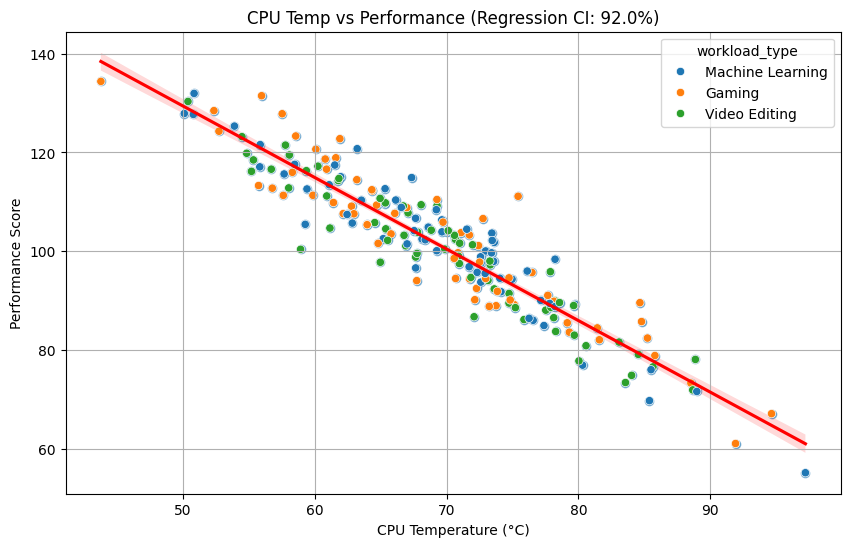

In [3]:
# Task Two

plt.figure(figsize=(10, 6))

sns.regplot(
    data=df,
    x="cpu_temperature",
    y="performance_score",
    ci=CONFIDENCE_REG * 100,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.5}
)

sns.scatterplot(data=df, x="cpu_temperature", y="performance_score", hue="workload_type")

plt.title(f"CPU Temp vs Performance (Regression CI: {CONFIDENCE_REG*100}%)")
plt.xlabel("CPU Temperature (°C)")
plt.ylabel("Performance Score")
plt.grid(True)
plt.show()

Mean Correlation: -0.9396
84% CI: [-0.9515, -0.9258]


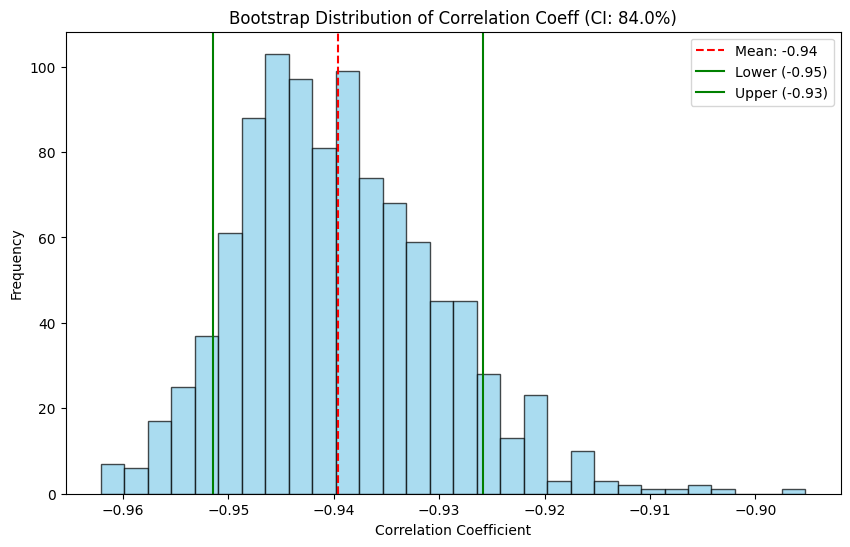

In [4]:
# Task Three

n_iterations = 1000
correlations = []

for _ in range(n_iterations):
    sample = df.sample(n=len(df), replace=True)
    corr = sample["cpu_temperature"].corr(sample["performance_score"])
    correlations.append(corr)

correlations = np.array(correlations)

alpha = 1 - CONFIDENCE_CORR
lower_p = (alpha / 2) * 100
upper_p = (1 - alpha / 2) * 100

lower_bound = np.percentile(correlations, lower_p)
upper_bound = np.percentile(correlations, upper_p)
mean_corr = np.mean(correlations)

print(f"Mean Correlation: {mean_corr:.4f}")
print(f"{int(CONFIDENCE_CORR*100)}% CI: [{lower_bound:.4f}, {upper_bound:.4f}]")

plt.figure(figsize=(10, 6))
plt.hist(correlations, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_corr, color='red', linestyle='--', label=f'Mean: {mean_corr:.2f}')
plt.axvline(lower_bound, color='green', linestyle='-', label=f'Lower ({lower_bound:.2f})')
plt.axvline(upper_bound, color='green', linestyle='-', label=f'Upper ({upper_bound:.2f})')
plt.title(f"Bootstrap Distribution of Correlation Coeff (CI: {CONFIDENCE_CORR*100}%)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.legend()
plt.show()

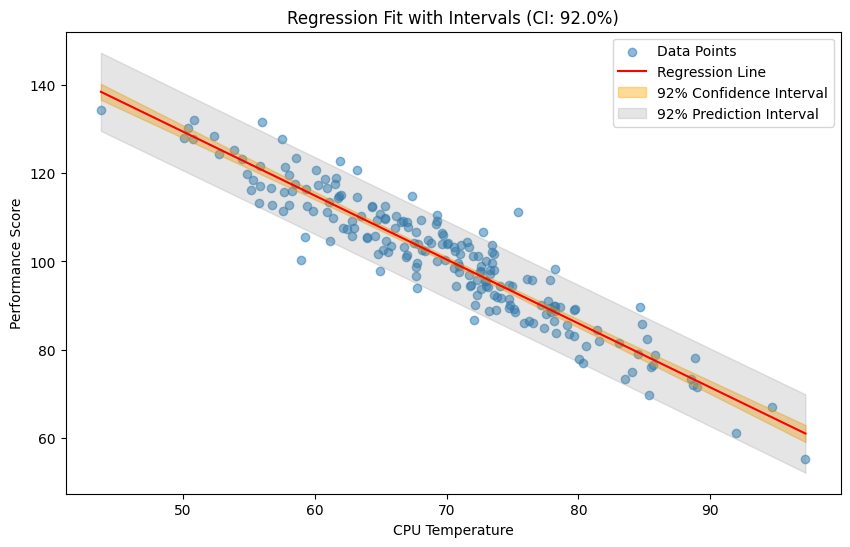

In [5]:
# Task Four

def regression_intervals(x, y, confidence=0.95):
    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit()
    predictions = model.get_prediction(x_with_const)
    summary_frame = predictions.summary_frame(alpha=1 - confidence)

    sort_idx = np.argsort(x)
    x_sorted = np.sort(x)

    results = {
        "model": model,
        "x_sorted": x_sorted,
        "y_pred": summary_frame["mean"].iloc[sort_idx],
        "ci_lower": summary_frame["mean_ci_lower"].iloc[sort_idx],
        "ci_upper": summary_frame["mean_ci_upper"].iloc[sort_idx],
        "pi_lower": summary_frame["obs_ci_lower"].iloc[sort_idx],
        "pi_upper": summary_frame["obs_ci_upper"].iloc[sort_idx]
    }
    return results

reg_results = regression_intervals(df["cpu_temperature"], df["performance_score"], confidence=CONFIDENCE_REG)

plt.figure(figsize=(10, 6))

plt.scatter(df["cpu_temperature"], df["performance_score"], alpha=0.5, label="Data Points")
plt.plot(reg_results["x_sorted"], reg_results["y_pred"], color="red", label="Regression Line")

plt.fill_between(
    reg_results["x_sorted"],
    reg_results["ci_lower"],
    reg_results["ci_upper"],
    color="orange", alpha=0.4, label=f"{int(CONFIDENCE_REG*100)}% Confidence Interval"
)

plt.fill_between(
    reg_results["x_sorted"],
    reg_results["pi_lower"],
    reg_results["pi_upper"],
    color="gray", alpha=0.2, label=f"{int(CONFIDENCE_REG*100)}% Prediction Interval"
)

plt.title(f"Regression Fit with Intervals (CI: {CONFIDENCE_REG*100}%)")
plt.xlabel("CPU Temperature")
plt.ylabel("Performance Score")
plt.legend()
plt.show()

Data Mean: 101.04
Critical Z-score: 1.70
Lower Critical Bound: 76.69
Upper Critical Bound: 125.39


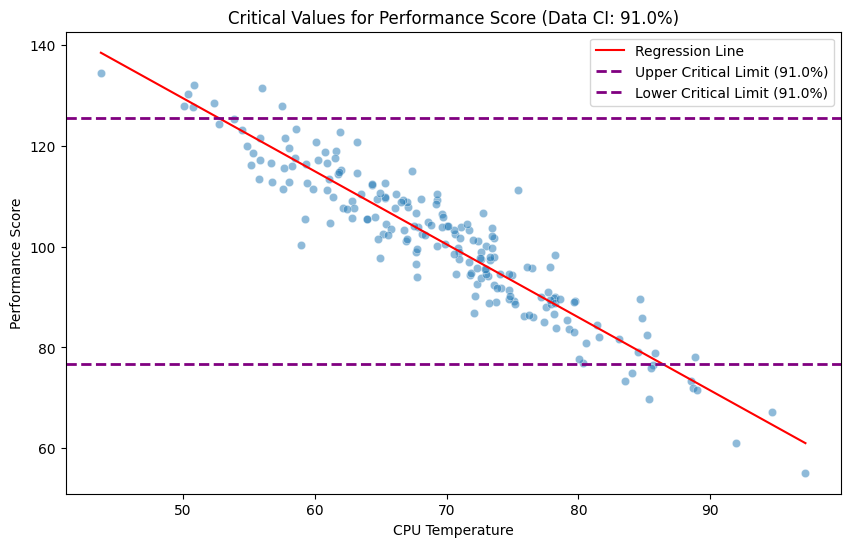

In [6]:
# Task Five

data_mean = df["performance_score"].mean()
data_std = df["performance_score"].std()

alpha_data = 1 - CONFIDENCE_DATA
z_score = norm.ppf(1 - alpha_data / 2)

upper_critical = data_mean + z_score * data_std
lower_critical = data_mean - z_score * data_std

print(f"Data Mean: {data_mean:.2f}")
print(f"Critical Z-score: {z_score:.2f}")
print(f"Lower Critical Bound: {lower_critical:.2f}")
print(f"Upper Critical Bound: {upper_critical:.2f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="cpu_temperature", y="performance_score", alpha=0.5)
plt.plot(reg_results["x_sorted"], reg_results["y_pred"], color="red", label="Regression Line")

plt.axhline(upper_critical, color='purple', linestyle='--', linewidth=2, label=f"Upper Critical Limit ({CONFIDENCE_DATA*100}%)")
plt.axhline(lower_critical, color='purple', linestyle='--', linewidth=2, label=f"Lower Critical Limit ({CONFIDENCE_DATA*100}%)")

plt.title(f"Critical Values for Performance Score (Data CI: {CONFIDENCE_DATA*100}%)")
plt.xlabel("CPU Temperature")
plt.ylabel("Performance Score")
plt.legend()
plt.show()

### Conclusion of the Pratical Exercise
The results confirmed that the linear regression model accurately depicts the negative relationship between CPU temperature and performance scores. The bootstrap method estimate the correlation coefficient confidence interval without normality assumptions so we observed that the prediction intervals were wider than the regression confidence intervals. In a nutshell, these results demonstrate that standard statistical methods are highly applicable for analyzing and predicting the system performance behavior.